### Scripts Python : processing

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd

##### Columns selection (MAJ possible selon les var pertinentes au modèle)

In [3]:
# Pour les nouvelles données
def select_columns(new_data):

    relevant_columns = ['Année_construction',
                        'Code_postal_(brut)',
                        'Coût_total_5_usages',
                        'Etiquette_DPE',
                        'Etiquette_GES',
                        'Hauteur_sous-plafond',
                        'Logement',
                        'Nombre_niveau_logement',
                        'Surface_habitable_logement',
                        'Type_bâtiment']

    new_data = new_data[relevant_columns]

    return new_data

##### Création de variables

In [4]:
# Pour les nouvelles données
def get_year_of_construct(value):
    year = int(value[:4])
    return year

In [5]:
# Pour les nouvelles données
def create_vars(new_data):
    if (not pd.Series(["Logement"]).isin(new_data.columns)[0]):
        new_data["Logement"] = 'neuf'

    if (not pd.Series(["Année_construction"]).isin(new_data.columns)[0]):
        from datetime import date
        new_data["Année_construction"] = new_data["Date_visite_diagnostiqueur"].apply(get_year_of_construct)

    return new_data

##### Cleaning and converting wrongly encoded data ("," vs ".")

In [6]:
# Pour les nouvelles données
def clean_and_convert(value):
    if pd.isna(value):  # Vérifie la présence de valeurs NaN ou de chaînes ' NaN'
        return value  # Préserve les NaN en tant que valeur None
    else:
        value = str(value).replace(',', '.')  # Remplace les virgules par des points
        return pd.to_numeric(value, errors='coerce')  # Conversion en valeur numérique

In [7]:
# # Pour les nouvelles données
# def cleaning_and_converting(new_data):
#     new_data.loc[:,"Besoin_ECS"] = new_data["Besoin_ECS"].apply(clean_and_convert)
#     new_data.loc[:,"Besoin_refroidissement"] = new_data["Besoin_refroidissement"].apply(clean_and_convert)
#     return new_data

##### **Embranchement 1** : Importation des données initiales et prétraitement (optimisé pour les débits internet limités)

In [8]:
# Importation des données
logements_neufs = pd.read_csv(os.path.join('data','raw','neufs.csv'))
logements_existants = pd.read_csv(os.path.join('data','raw','existents.csv'))

C:\Users\DELL\AppData\Local\Temp\ipykernel_5916\1169846585.py:2: DtypeWarning: Columns (80,100,111,112,132,133) have mixed types. Specify dtype option on import or set low_memory=False.
  logements_neufs = pd.read_csv(os.path.join('data','raw','neufs.csv'))
C:\Users\DELL\AppData\Local\Temp\ipykernel_5916\1169846585.py:3: DtypeWarning: Columns (159,191,202,208,214,215,218,219,220,221,228,232) have mixed types. Specify dtype option on import or set low_memory=False.
  logements_existants = pd.read_csv(os.path.join('data','raw','existents.csv'))


In [9]:
# Pour les anciens
logements_existants["Logement"] = "ancien"
logements_existants["Année_construction"] = logements_existants["Date_visite_diagnostiqueur"].apply(get_year_of_construct)

# Pour les neufs (et les futures données qui seront produites)
logements_neufs = create_vars(logements_neufs)

In [10]:
logements_neufs = select_columns(logements_neufs)
logements_neufs.shape

(59213, 10)

In [11]:
logements_existants = select_columns(logements_existants)
logements_existants.shape

(398114, 10)

In [12]:
# logements_existants = cleaning_and_converting(logements_existants)
# logements_neufs = cleaning_and_converting(logements_neufs)

In [13]:
df = pd.concat([logements_existants, logements_neufs], ignore_index=True, axis=0)

In [14]:
# A décommenter si on veut produire le csv du dataset déjà pré-traité
df.to_csv(os.path.join('data','processed','full_data_bretagne.csv'), index=False, sep=";", encoding="utf-8-sig")

##### **Embranchement 2** : Importation des données pré-traitées

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
import pandas as pd

df = pd.read_csv(os.path.join('data','processed','full_data_bretagne.csv'), sep=";")

##### Split train/test

In [15]:
def data_split(data, target="Etiquette_DPE", test_size=0.3, stratify=True, seed=0):
    from sklearn.model_selection import train_test_split

    if stratify:
        return train_test_split(data, test_size=test_size, random_state=seed, stratify=data[target])
    else:
        return train_test_split(data, test_size=test_size, random_state=seed)

In [16]:
X_train, X_test = data_split(df, target="Etiquette_DPE", test_size=0.3, stratify=True, seed=0)

##### Qualitative and quantitative data processing (after train/test split)

In [17]:
# Pour toutes les données (cf. paramètres de la fonction)

# exporter params d'un retrain pour les recharger tant que retrain=False
# exporter fit du train (original_data) tant que retrain=False (optimisation des calculs)
def quali_quanti_preprocessing(original_data, new_data):
    import pandas as pd
    
    # QUALITATIVE PREPROCESSING

    # On remplace des adresses inconnues par la chaîne "inconnu"
    # new_data['Identifiant__BAN'] = new_data['Identifiant__BAN'].fillna('inconnu')
    # new_data['Nom__rue_(BAN)'] = new_data['Nom__rue_(BAN)'].fillna('inconnu')
    # new_data['Adresse_(BAN)'] = new_data['Adresse_(BAN)'].fillna('inconnu')
    # new_data['Adresse_brute'] = new_data['Adresse_brute'].fillna('inconnu')
    
    # Le code est encodé parfois en tant que chaîne ou entier. On uniformise en chaîne de caractères
    # original_data['Code_INSEE_(BAN)'] = original_data['Code_INSEE_(BAN)'].apply(lambda x: str(x) if pd.notna(x) else x)
    # new_data['Code_INSEE_(BAN)'] = new_data['Code_INSEE_(BAN)'].apply(lambda x: str(x) if pd.notna(x) else x)

    quali_data_new = new_data.select_dtypes(include=['object'])
    for column in quali_data_new.columns:
        # Calcul de la proportion (probabilité) des modalités dans chaque variable qualitative
        proportions = original_data[column].value_counts(normalize=True)
        
        # On applique la fonction à la colonne
        filling = proportions.sample(weights=proportions, replace=True).index[0]
        original_data[column] = original_data[column].fillna(filling)
        filling = proportions.sample(weights=proportions, replace=True).index[0]
        quali_data_new[column] = quali_data_new[column].fillna(filling)
        

        # if retrain:
        #     quali_data_orig = original_data.select_dtypes(include=['object'])
        #     quali_data_orig[column] = quali_data_orig.apply(impute_with_proportions, axis=1)
    

    # QUANTITATIVE PREPROCESSING
    ## Missing values
    from sklearn.impute import SimpleImputer
    quanti_data_new = new_data.select_dtypes(exclude=['object'])
    imputer = SimpleImputer(strategy="median")
    original_data[quanti_data_new.columns] = imputer.fit_transform(original_data[quanti_data_new.columns])
    quanti_data_new[quanti_data_new.columns] = imputer.transform(quanti_data_new)

    import pickle as pk
    pk.dump(imputer, open(os.path.join("objects","median_imputer.pkl"), "wb"))
    
    new_data_processed = pd.concat([quali_data_new, quanti_data_new], axis=1)
    return original_data, new_data_processed

In [18]:
orig, new = quali_quanti_preprocessing(X_train, X_test)

##### Split regressors/target

In [25]:
def define_target(train, test, target="Etiquette_DPE"):
    X_train = train[train.columns.difference([target])]
    y_train = train[target]
    X_test = test[test.columns.difference([target])]
    y_test = test[target]
    return X_train, X_test, y_train, y_test

In [26]:
X_train, X_test, y_train, y_test = define_target(orig, new, target="Etiquette_DPE")

#### Split des données quanti et quali

In [36]:
def to_drop_before_model(case="classification"):
    if case=="classification":
        return ["Adresse_brute","Code_INSEE_(BAN)", "Date_fin_validité_DPE", "Date_réception_DPE", 
           "Date_visite_diagnostiqueur", "Date_établissement_DPE", "Identifiant__BAN", "N°DPE", "_geopoint"]
    elif case=="regression":
        return []
    else:
        print("Error. Only 'classification' or 'regression' supported")
        return

In [37]:
to_drop = to_drop_before_model(case="classification")

In [27]:
def split_type(X_train, X_test, to_drop):
    quali_train = X_train.select_dtypes(include="object")
    quali_train = quali_train.drop(to_drop, axis=1) # Inutile de faire une ACM sur une variable avec autant de modalités possibles
    quali_test = X_test.select_dtypes(include="object")
    quali_test = quali_test.drop(to_drop, axis=1) # Inutile de faire une ACM sur une variable avec autant de modalités possibles

    quantit_train = X_train.select_dtypes(exclude="object")
    quantit_test = X_test.select_dtypes(exclude="object")

    from sklearn.preprocessing import OneHotEncoder

    encoder = OneHotEncoder()

    encoder.fit(pd.concat([quali_train, quali_test], axis=0))
    #print(encoder.get_feature_names_out(quali_train.columns))
    quali_train_encoded = encoder.transform(quali_train).toarray()
    qualit_train = pd.DataFrame(quali_train_encoded, index=quali_train.index, columns=encoder.get_feature_names_out(quali_train.columns))
    quali_test_encoded = encoder.transform(quali_test).toarray()
    qualit_test = pd.DataFrame(quali_test_encoded, index=quali_test.index, columns=encoder.get_feature_names_out(quali_test.columns))
    # print(quali_train.apply(pd.unique).apply(len))

    import pickle as pk
    pk.dump(encoder, open(os.path.join("objects","OHE.pkl"), "wb"))

    return qualit_train, qualit_test, quantit_train, quantit_test

In [28]:
quali_train, quali_test, quanti_train, quanti_test = split_type(X_train, X_test, to_drop=[])

#### ACM

In [ ]:
def chunking_MCA(quali_train, quali_test, n_components, n_iter, seed, chunk_size):
    # Exportation en csv pour le chunking
    quali_train.to_csv(os.path.join('data','processed','quali_train.csv'), index=False, sep=";", encoding="utf-8-sig")
    quali_test.to_csv(os.path.join('data','processed','quali_test.csv'), index=False, sep=";", encoding="utf-8-sig")

    import prince

    mca = prince.MCA(
        n_components=n_components,
        n_iter=n_iter,
        copy=False,
        check_input=False,
        random_state=seed,
        engine="sklearn",
        handle_unknown="error"  # paramètre identique à celui de sklearn.preprocessing.OneHotEncoder
    )

    print("MCA : fitting to train set")
    quali_train_mca_lst = []
    i = 0
    for chunk in pd.read_csv(os.path.join('data','processed','quali_train.csv'), sep=';', chunksize=chunk_size):
        mca = mca.fit(chunk)
        quali_train_mca_lst.append(mca.transform(chunk))
        i += 1
        if i%100==0:
            print((i*chunk_size)/quali_train.shape[0])
    
    quali_train_mca = pd.DataFrame()
    for elem in quali_train_mca_lst:
        quali_train_mca = pd.concat([quali_train_mca, pd.DataFrame(elem)], axis=0, ignore_index=True)

    print("MCA : transforming test set")

    quali_test_mca_lst = []
    i = 0
    for chunk in pd.read_csv(os.path.join('data','processed','quali_test.csv'), sep=';', chunksize=chunk_size):
        quali_test_mca_lst.append(mca.transform(chunk))
        i += 1
        if i%50==0:
            print((i*chunk_size)/quali_test.shape[0])
    
    quali_test_mca = pd.DataFrame()
    for elem in quali_test_mca_lst:
        quali_test_mca = pd.concat([quali_test_mca, pd.DataFrame(elem)], axis=0, ignore_index=True)
    
    os.remove(os.path.join('data','processed','quali_train.csv'))
    os.remove(os.path.join('data','processed','quali_test.csv'))

    return quali_train_mca, quali_test_mca

In [46]:
quali_train_mca, quali_test_mca =  chunking_MCA(quali_train, quali_test, n_components=10, n_iter=10, seed=0, chunk_size=1000)

MCA : fitting to train set
0.312375049980008
0.624750099960016
0.9371251499400239
MCA : transforming test set
0.3644341431059993
0.7288682862119986


In [29]:
def merge_type_back(quali_train_mca, quali_test_mca, quanti_train, quanti_test, train_index, test_index):
    # Convert colnames to str
    quali_train_mca.columns = quali_train_mca.columns.astype(str)
    quali_test_mca.columns = quali_test_mca.columns.astype(str)

    quali_train_mca.set_index(train_index, inplace=True)
    quali_test_mca.set_index(test_index, inplace=True)

    # Concaténer, quali_train et quanti_train de même avec test
    X_train_mca = pd.concat([quanti_train, quali_train_mca], axis=1)
    X_test_mca = pd.concat([quanti_test, quali_test_mca], axis=1)

    return X_train_mca, X_test_mca

In [30]:
X_train_mca, X_test_mca = merge_type_back(quali_train, quali_test, quanti_train, quanti_test, X_train.index, X_test.index)

### Standardisation

In [49]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_mca_scaled = pd.DataFrame(scaler.fit_transform(X_train_mca), index=X_train_mca.index, columns=X_train_mca.columns)
X_test_mca_scaled = pd.DataFrame(scaler.transform(X_test_mca), index=X_test_mca.index, columns=X_test_mca.columns)

### Feature selection

In [82]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, min_samples_split=5, random_state=0, verbose=1)
rf.fit(X_train_mca, y_train)
y_pred = rf.predict(X_test_mca)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  2.5min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.9s


In [83]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       1.00      1.00      1.00      8402
           B       0.99      1.00      1.00      7973
           C       1.00      1.00      1.00     41301
           D       1.00      1.00      1.00     38342
           E       0.99      1.00      0.99     24184
           F       0.99      0.98      0.99     10051
           G       0.99      0.99      0.99      6946

    accuracy                           1.00    137199
   macro avg       0.99      0.99      0.99    137199
weighted avg       1.00      1.00      1.00    137199



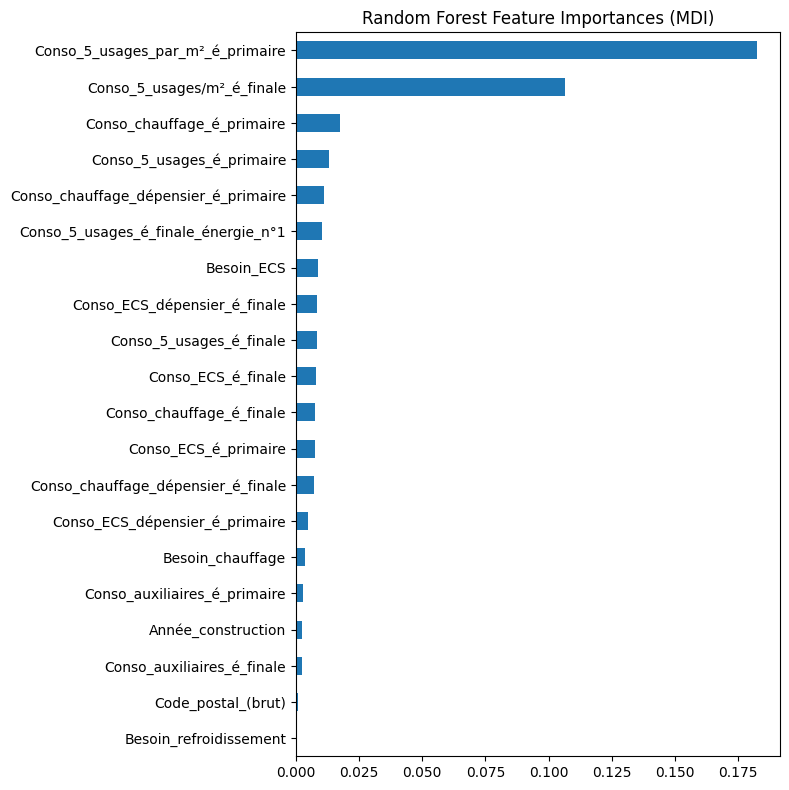

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))

feature_names = rf.feature_names_in_[:20]

mdi_importances = pd.Series(
    rf.feature_importances_[:20], index=feature_names
).sort_values(ascending=True)

ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()

### Modélisation

In [ ]:
vars = ['Année_construction',
        'Surface_habitable_logement',
        'Coût_total_5_usages',
        'Etiquette_GES',
        'Code_postal_(brut)',
        'Logement',
        'Type_bâtiment',
        'Hauteur_sous-plafond',
        'Nombre_niveau_logement',
        'Etiquette_DPE'
        ]
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()

encoder.fit(X_train[vars])

,Année_construction,Surface_habitable_logement,Coût_total_5_usages,Etiquette_GES,Code_postal_(brut),Type_bâtiment,Hauteur_sous-plafond,Logement,Nombre_niveau_logement
314133,2024.0,62.7,614.5,C,35850.0,appartement,2.5,ancien,1.0
299757,2023.0,97.6,2034.6,E,35700.0,appartement,2.6,ancien,1.0
428276,2024.0,141.6,492.0,A,35235.0,maison,2.5,neuf,1.0
281330,2023.0,44.0,446.1,C,35530.0,appartement,2.5,ancien,1.0
193159,2023.0,100.6,1119.5,D,35000.0,appartement,2.5,ancien,1.0
...,...,...,...,...,...,...,...,...,...
96859,2023.0,40.0,479.4,D,29200.0,appartement,2.5,ancien,1.0
371507,2023.0,48.0,1214.0,C,56470.0,maison,2.4,ancien,1.0
356423,2022.0,149.7,2705.0,E,56320.0,maison,2.6,ancien,2.0
214429,2024.0,39.0,559.0,A,35135.0,appartement,2.4,ancien,1.0


In [ ]:
vars = ['Année_construction',
        'Code_postal_(brut)',
        'Coût_total_5_usages',
        'Hauteur_sous-plafond',
        'Nombre_niveau_logement',
        'Surface_habitable_logement',
        'Etiquette_GES_A',
        'Etiquette_GES_B',
        # 'Etiquette_GES_C',
        'Etiquette_GES_D',
        'Etiquette_GES_E',
        'Etiquette_GES_F',
        'Etiquette_GES_G',
        'Logement_neuf',
        # 'Type_bâtiment_appartement',
        'Type_bâtiment_immeuble',
        'Type_bâtiment_maison'
        ]

In [37]:
X_train_mca[vars].corr()

,Année_construction,Code_postal_(brut),Coût_total_5_usages,Etiquette_GES_A,Etiquette_GES_B,Etiquette_GES_D,Etiquette_GES_E,Etiquette_GES_F,Etiquette_GES_G,Hauteur_sous-plafond,Logement_neuf,Nombre_niveau_logement,Surface_habitable_logement,Type_bâtiment_immeuble,Type_bâtiment_maison
Année_construction,1.000000,-0.024801,0.014375,0.021327,-0.007802,0.001245,-0.027358,-0.037204,-0.028258,-0.003631,-0.037859,-0.009730,-0.017971,0.048581,-0.051265
Code_postal_(brut),-0.024801,1.000000,-0.017572,0.041219,-0.007541,-0.037187,-0.015397,-0.024255,-0.015204,-0.000273,0.052766,0.018759,0.004995,0.007345,-0.017295
Coût_total_5_usages,0.014375,-0.017572,1.000000,-0.111724,-0.022634,0.044798,0.078050,0.104090,0.095719,-0.000375,-0.123461,0.010584,0.220867,0.539520,0.093203
Etiquette_GES_A,0.021327,0.041219,-0.111724,1.000000,-0.306959,-0.190077,-0.128907,-0.095465,-0.061392,0.002618,0.307021,-0.016671,0.070285,-0.029052,0.126697
Etiquette_GES_B,-0.007802,-0.007541,-0.022634,-0.306959,1.000000,-0.232061,-0.157380,-0.116551,-0.074952,-0.002489,-0.118233,0.001833,-0.055916,-0.016902,0.036225
Etiquette_GES_D,0.001245,-0.037187,0.044798,-0.190077,-0.232061,1.000000,-0.097454,-0.072172,-0.046412,-0.001246,-0.145890,-0.002609,0.010810,0.007542,-0.059671
Etiquette_GES_E,-0.027358,-0.015397,0.078050,-0.128907,-0.157380,-0.097454,1.000000,-0.048945,-0.031476,-0.000706,-0.099110,0.010400,0.039807,-0.009866,0.064656
Etiquette_GES_F,-0.037204,-0.024255,0.104090,-0.095465,-0.116551,-0.072172,-0.048945,1.000000,-0.023310,-0.000507,-0.073405,0.010513,0.043791,-0.012518,0.123184
Etiquette_GES_G,-0.028258,-0.015204,0.095719,-0.061392,-0.074952,-0.046412,-0.031476,-0.023310,1.000000,-0.000288,-0.046467,0.005606,0.013705,-0.012659,0.099197
Hauteur_sous-plafond,-0.003631,-0.000273,-0.000375,0.002618,-0.002489,-0.001246,-0.000706,-0.000507,-0.000288,1.000000,0.003953,-0.000368,0.000306,-0.000452,0.000004


In [38]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=5, min_samples_split=5, max_depth=None, random_state=0, verbose=1)
rf.fit(X_train_mca[vars], y_train)
y_pred = rf.predict(X_test_mca[vars])

In [89]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

rf = RandomForestClassifier()
cv = StratifiedKFold(5)
params = {'n_estimators': [100],
          'min_samples_split': [5],
          'max_depth': [20, None]}
grid = GridSearchCV(rf, param_grid=params, scoring="accuracy", cv=cv, verbose=2)
grid.fit(X_train_mca[vars], y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END max_depth=20, min_samples_split=5, n_estimators=100; total time=  48.2s
[CV] END max_depth=20, min_samples_split=5, n_estimators=100; total time=  46.7s
[CV] END max_depth=20, min_samples_split=5, n_estimators=100; total time=  45.5s
[CV] END max_depth=20, min_samples_split=5, n_estimators=100; total time=  45.7s
[CV] END max_depth=20, min_samples_split=5, n_estimators=100; total time=  46.2s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=  53.7s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=  52.3s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=  52.3s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=  51.5s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=  52.2s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'max_depth': [20, None], 'min_samples_split': [5],
                         'n_estimators': [100]},
             scoring='accuracy', verbose=2)

In [ ]:
# Quali OHE
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.98      0.97      0.97      8402
           B       0.91      0.85      0.88      7973
           C       0.94      0.95      0.94     41301
           D       0.91      0.93      0.92     38342
           E       0.89      0.89      0.89     24184
           F       0.86      0.81      0.83     10051
           G       0.93      0.87      0.90      6946

    accuracy                           0.91    137199
   macro avg       0.91      0.90      0.90    137199
weighted avg       0.91      0.91      0.91    137199



In [ ]:
# Sans quali OHE
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.96      0.94      0.95      8402
           B       0.87      0.81      0.84      7973
           C       0.92      0.94      0.93     41301
           D       0.89      0.91      0.90     38342
           E       0.87      0.85      0.86     24184
           F       0.83      0.78      0.80     10051
           G       0.90      0.84      0.87      6946

    accuracy                           0.89    137199
   macro avg       0.89      0.87      0.88    137199
weighted avg       0.89      0.89      0.89    137199



In [ ]:
# Emission_GES_ECS
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.97      0.97      0.97      8402
           B       0.91      0.87      0.89      7973
           C       0.94      0.95      0.95     41301
           D       0.90      0.92      0.91     38342
           E       0.88      0.87      0.88     24184
           F       0.84      0.80      0.82     10051
           G       0.92      0.85      0.88      6946

    accuracy                           0.91    137199
   macro avg       0.91      0.89      0.90    137199
weighted avg       0.91      0.91      0.91    137199



In [ ]:
# Etiquettes GES A + G
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.97      0.98      0.97      8402
           B       0.92      0.87      0.90      7973
           C       0.95      0.96      0.95     41301
           D       0.91      0.92      0.92     38342
           E       0.88      0.87      0.88     24184
           F       0.85      0.82      0.83     10051
           G       0.95      0.86      0.90      6946

    accuracy                           0.92    137199
   macro avg       0.92      0.90      0.91    137199
weighted avg       0.92      0.92      0.92    137199



In [66]:
# Etiquettes GES A - G
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.96      0.97      0.96      8402
           B       0.92      0.90      0.91      7973
           C       0.94      0.98      0.96     41301
           D       0.91      0.90      0.91     38342
           E       0.89      0.88      0.88     24184
           F       0.86      0.84      0.85     10051
           G       0.91      0.82      0.87      6946

    accuracy                           0.92    137199
   macro avg       0.91      0.90      0.90    137199
weighted avg       0.92      0.92      0.92    137199



In [ ]:
# 50 arbres
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.96      0.97      0.96      8402
           B       0.92      0.90      0.91      7973
           C       0.94      0.98      0.96     41301
           D       0.91      0.90      0.91     38342
           E       0.89      0.88      0.88     24184
           F       0.86      0.83      0.84     10051
           G       0.91      0.82      0.86      6946

    accuracy                           0.92    137199
   macro avg       0.91      0.90      0.90    137199
weighted avg       0.91      0.92      0.91    137199



In [ ]:
# 10 arbres
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.95      0.96      0.96      8402
           B       0.91      0.89      0.90      7973
           C       0.94      0.97      0.96     41301
           D       0.90      0.90      0.90     38342
           E       0.88      0.87      0.87     24184
           F       0.84      0.82      0.83     10051
           G       0.88      0.81      0.85      6946

    accuracy                           0.91    137199
   macro avg       0.90      0.89      0.89    137199
weighted avg       0.91      0.91      0.91    137199



In [39]:
# 5 arbres
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.95      0.95      0.95      8402
           B       0.90      0.88      0.89      7973
           C       0.94      0.97      0.95     41301
           D       0.89      0.89      0.89     38342
           E       0.86      0.85      0.86     24184
           F       0.83      0.80      0.81     10051
           G       0.87      0.80      0.83      6946

    accuracy                           0.90    137199
   macro avg       0.89      0.88      0.88    137199
weighted avg       0.90      0.90      0.90    137199



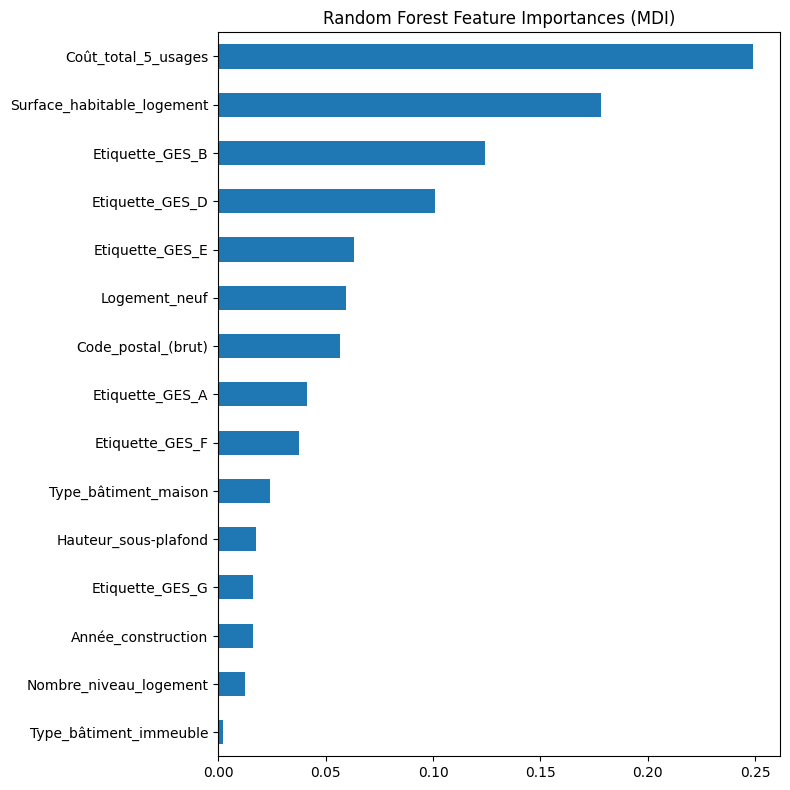

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))

feature_names = rf.feature_names_in_

mdi_importances = pd.Series(
    rf.feature_importances_, index=feature_names
).sort_values(ascending=True)

ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()

In [41]:
import pickle as pk

pk.dump(rf, open(os.path.join("models","rf_tuned_classification.pkl"), "wb"))

In [53]:
import pickle as pk
import os
with open(os.path.join("models","rf_tuned_classification.pkl"), "rb") as file:
    rf = pk.load(file)
file.close()

In [54]:
rf.feature_names_in_

array(['Année_construction', 'Code_postal_(brut)', 'Coût_total_5_usages',
       'Etiquette_GES_A', 'Etiquette_GES_B', 'Etiquette_GES_D',
       'Etiquette_GES_E', 'Etiquette_GES_F', 'Etiquette_GES_G',
       'Hauteur_sous-plafond', 'Logement_neuf', 'Nombre_niveau_logement',
       'Surface_habitable_logement', 'Type_bâtiment_immeuble',
       'Type_bâtiment_maison'], dtype=object)

In [52]:
import pandas as pd
from pipeline import Pipeline

new = pd.DataFrame([{"Année_construction":2024,
                     "Surface_habitable_logement":200,
                     "Coût_total_5_usages":10000,
                     "Etiquette_GES":"C",
                     "Code_postal_(brut)":35660,
                     "Logement":"neuf",
                     "Type_bâtiment":"maison",
                     "Hauteur_sous-plafond":3,
                     "Nombre_niveau_logement":2
                     }])

Pipeline(new)

ValueError: The feature names should match those that were passed during fit.
Feature names must be in the same order as they were in fit.


In [70]:
new

,Année_construction,Surface_habitable_logement,Coût_total_5_usages,Etiquette_GES,Code_postal_(brut),Type_bâtiment,Hauteur_sous-plafond,Logement,Nombre_niveau_logement
0,2024,200,10000,C,35660,maison,3,neuf,2
